In [1]:
"""
Periodicity Analysis of Weather Variables
=========================================

This notebook analyzes the periodic patterns in weather variables using various time series
analysis techniques including:
- Fourier transforms
- Autocorrelation analysis
- Power spectral density analysis

The goal is to identify significant periodicities in different atmospheric variables
that could inform the weather analogue model.
"""

# Standard library imports
import os
import sys
from datetime import datetime

# Data handling imports
import numpy as np
import pandas as pd
import xarray as xr

# Statistical and signal processing imports
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates
from matplotlib.ticker import FormatStrFormatter

# Optional visualization imports
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from windrose import WindroseAxes

In [2]:
def setup_environment():
    """
    Set up the project environment by configuring paths and importing project modules.
    
    Returns:
        str: Current working directory
    """
    try:
        # Navigate to project root directory
        os.chdir("../")
    except Exception as e:
        print(f"Error changing directory: {e}")
    
    # Get and print current working directory
    current_directory = os.getcwd()
    print(f"Current Directory: {current_directory}")
    
    # Add notebooks directory to path
    notebooks_path = os.path.abspath(os.path.join(current_directory, "notebooks"))
    if notebooks_path not in sys.path:
        sys.path.append(notebooks_path)
    
    return current_directory

def set_plot_style(size=12):
    """
    Configure consistent matplotlib plot style settings
    
    Args:
        size (int): Base font size for plots
    """
    plt.rcParams.update({
        'font.size': size,
        'axes.titlesize': size+2,
        'axes.labelsize': size,
        'xtick.labelsize': size-2,
        'ytick.labelsize': size-2,
        'legend.fontsize': size-2,
        'figure.figsize': (10, 6),
        'figure.dpi': 100,
    })

# Setup the environment
current_dir = setup_environment()

# Import project utilities
try:
    from utils.utils import load_json_config
    from utils.utils_data import read_netcdf, read_netcdf_raw
    print("Successfully imported project utilities")
except ImportError as e:
    print(f"Error importing project utilities: {e}")

# Apply consistent plotting style
set_plot_style()

Current Directory: /home/yuhan/Desktop/Master/yu-ml-weather-analogue
Successfully imported project utilities


## Data Loading and Preprocessing

In this section, we load weather data from preprocessed files and extract time series for analysis.

In [6]:
def load_weather_data(variables, frequency, time_unit, method, preprocessing, year_range):
    """
    Load weather data based on specified parameters
    
    Args:
        variables (str): String identifying the variables (e.g., 'd2muvmslr')
        frequency (int): Temporal frequency
        time_unit (str): Time unit ('h' for hours, 'd' for days)
        method (str): Resampling method
        preprocessing (str): Preprocessing method
        year_range (tuple): Tuple of (start_year, end_year)
        
    Returns:
        list: Raw data from netCDF file
    """
    # Construct file path
    file_path = f"/home/yuhan/Desktop/Master/data/processed/d2muvmslr_1h_none_raw_20042020.h5"
    print(f"Loading data from: {file_path}")
    
    # Load the data
    try:
        data = read_netcdf(file_path)
        print(f"Data loaded successfully with {len(data)} time points")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Define data parameters
variables = "d2muvmslr"
variable_list = ["d2m", "u", "v", "msl", "r"]
selected_frequency = 1
time_unit = "h"
resample_method = "none"
preprocessing_method = "raw"
year_range = (2004, 2020)

# Load weather variables data
all_variables_data = load_weather_data(
    variables=variables,
    frequency=selected_frequency,
    time_unit=time_unit,
    method=resample_method,
    preprocessing=preprocessing_method,
    year_range=year_range
)

Loading data from: /home/yuhan/Desktop/Master/data/processed/d2muvmslr_1h_none_raw_20042020.h5
Data loaded successfully with 146736 time points
Data loaded successfully with 146736 time points


In [7]:
def extract_time_series(data, location=(17, 17)):
    """
    Extract time series data for each variable at a specific location
    
    Args:
        data (list): Raw data from netCDF file
        location (tuple): Grid point coordinates (x, y)
        
    Returns:
        pandas.DataFrame: Time series data for each variable
    """
    # Initialize lists to store data
    d2m, u, v, msl, r, date_times = [], [], [], [], [], []
    x, y = location
    
    # Extract data at the specified location
    for item in data:
        date_times.append(item[0])
        d2m.append(item[1][0][y][x])
        u.append(item[1][1][y][x])
        v.append(item[1][2][y][x])
        msl.append(item[1][3][y][x])
        r.append(item[1][4][y][x])
    
    # Convert to numpy arrays
    d2m = np.array(d2m)
    u = np.array(u)
    v = np.array(v)
    msl = np.array(msl)
    r = np.array(r)
    
    # Convert datetime strings to pandas datetime objects
    date_times = pd.to_datetime(date_times)
    
    # Calculate wind speed and direction
    wind_speed = np.sqrt(u**2 + v**2)
    wind_direction = (np.arctan2(v, u) * (180 / np.pi) - 90) % 360
    
    # Create DataFrame
    df = pd.DataFrame(
        {
            "d2m": d2m,
            "u": u,
            "v": v,
            "msl": msl,
            "r": r,
            "windspeed": wind_speed,
            "direction": wind_direction,
            "datetime": date_times,
        },
        index=date_times
    )
    
    # Add month column for seasonal analysis
    df["month"] = df.index.month
    
    return df

# Extract time series at a central location (grid point 17,17)
central_location = (17, 17)
all_variables_df = extract_time_series(all_variables_data, central_location)

# Create resampled versions for different time scales
all_variables_month = all_variables_df.resample("ME").mean()  # Monthly average
all_variables_annual = all_variables_df.resample("YE").mean()  # Annual average

# Display data summary
print(f"Data shape: {all_variables_df.shape}")
print("\nFirst few rows:")
print(all_variables_df.head())
print("\nLast few rows:")
print(all_variables_df.tail())

Data shape: (146736, 9)

First few rows:
                            d2m          u          v            msl  \
2004-04-06 00:00:00  274.818172  11.733071 -14.363482  101010.838882   
2004-04-06 01:00:00  274.642188  11.786947 -13.703199  101008.408896   
2004-04-06 02:00:00  274.544054  11.651684 -13.387742  101009.292527   
2004-04-06 03:00:00  274.596136  11.660855 -13.052705  100985.765848   
2004-04-06 04:00:00  274.505678  11.735364 -13.003755  100977.923621   

                             r  windspeed   direction            datetime  \
2004-04-06 00:00:00  51.420153  18.546552  219.244293 2004-04-06 00:00:00   
2004-04-06 01:00:00  54.221952  18.075115  220.700810 2004-04-06 01:00:00   
2004-04-06 02:00:00  57.857972  17.748053  221.033861 2004-04-06 02:00:00   
2004-04-06 03:00:00  59.218846  17.502818  221.776546 2004-04-06 03:00:00   
2004-04-06 04:00:00  56.320142  17.516176  222.064977 2004-04-06 04:00:00   

                     month  
2004-04-06 00:00:00      4  
2004-

## Fourier Transform Analysis

Fourier transform is used to identify frequency components in time series data. Here we analyze the temperature (d2m) time series using Fourier analysis.

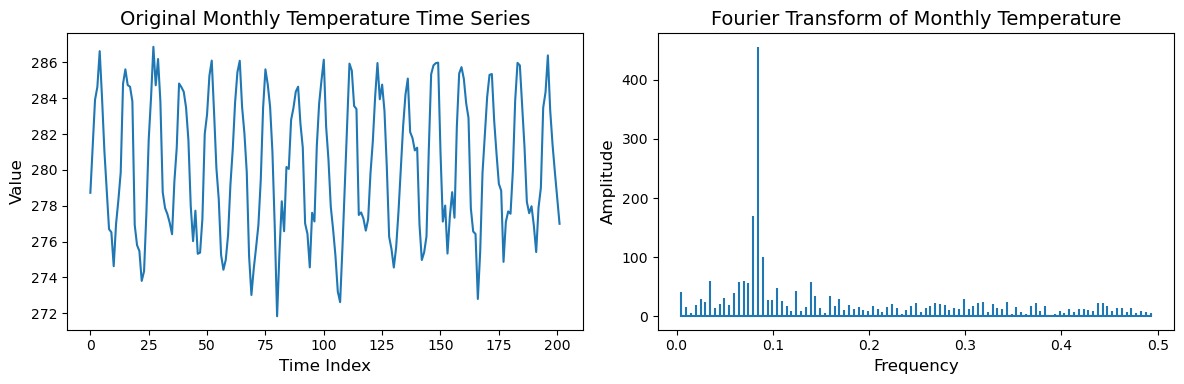

In [8]:
def perform_fourier_analysis(time_series, variable_name='Temperature'):
    """
    Perform Fourier transform analysis on a time series
    
    Args:
        time_series (array-like): The time series data to analyze
        variable_name (str): Name of the variable for plot titles
        
    Returns:
        tuple: (frequencies, amplitudes) of the Fourier transform
    """
    # Convert to list if not already
    fft_data = list(time_series)
    
    # Create time index
    fft_time = np.linspace(0, len(fft_data), len(fft_data))
    fft_time = [int(time) for time in fft_time]
    
    # Perform Fourier transform
    fft_result = np.fft.fft(fft_data)
    fft_freq = np.fft.fftfreq(len(fft_time), d=(fft_time[1] - fft_time[0]))
    
    # Keep only positive frequencies
    n = len(fft_result) // 2
    fft_result = fft_result[1:n]
    fft_freq = fft_freq[1:n]
    
    # Calculate amplitude
    amplitude = np.abs(fft_result)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    # Original time series
    plt.subplot(1, 2, 1)
    plt.plot(fft_time, fft_data)
    plt.title(f"Original {variable_name} Time Series")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    
    # Fourier transform
    plt.subplot(1, 2, 2)
    plt.stem(fft_freq, amplitude, markerfmt=" ", basefmt="#1f77b4")
    plt.title(f"Fourier Transform of {variable_name}")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()
    
    return fft_freq, amplitude

# Perform Fourier analysis on monthly temperature data
freq_d2m, amp_d2m = perform_fourier_analysis(
    all_variables_month["d2m"], 
    variable_name="Monthly Temperature"
)

## Autocorrelation Analysis

Autocorrelation analysis helps identify repeating patterns in time series data. We analyze both the autocorrelation function (ACF) and partial autocorrelation function (PACF) to detect seasonality and periodicity.

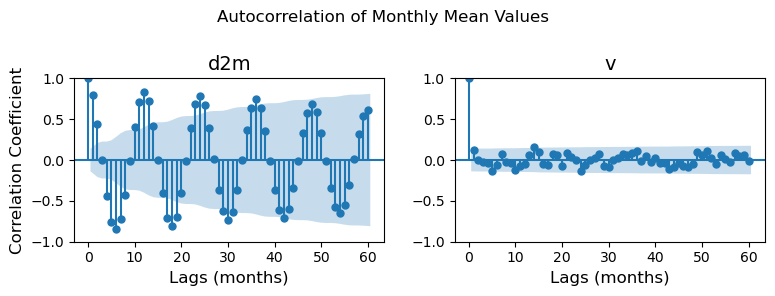

<Figure size 1000x400 with 0 Axes>

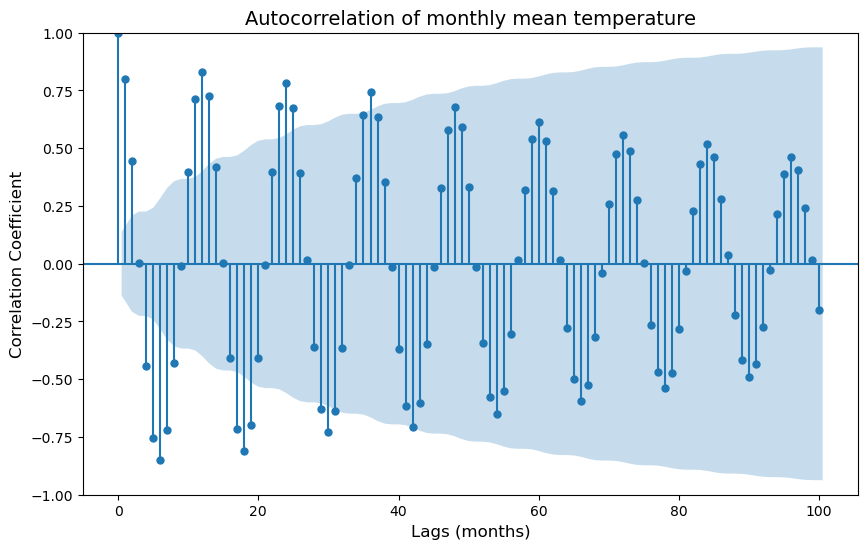

<Figure size 1000x400 with 0 Axes>

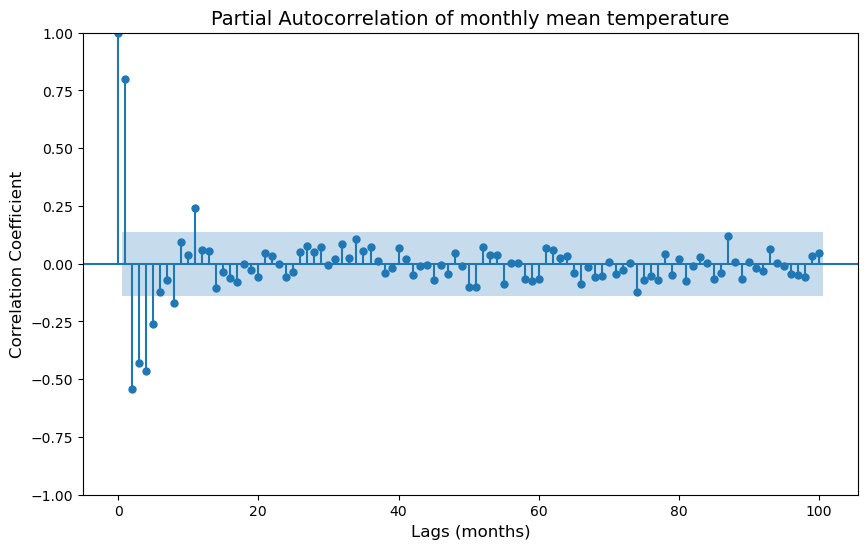

In [9]:
def plot_autocorrelation_comparison(data, variables, max_lags=60, title=None):
    """
    Create comparative autocorrelation plots for multiple variables
    
    Args:
        data (pandas.DataFrame): DataFrame containing the time series data
        variables (list): List of variable names to plot
        max_lags (int): Maximum number of lags to include
        title (str, optional): Title for the figure
    """
    # Determine subplot dimensions
    n_vars = len(variables)
    fig, axes = plt.subplots(1, n_vars, figsize=(4*n_vars, 3))
    
    # Handle single variable case
    if n_vars == 1:
        axes = [axes]
    
    # Plot ACF for each variable
    for i, var in enumerate(variables):
        plot_acf(data[var], lags=max_lags, ax=axes[i])
        axes[i].set_title(f"{var}")
        axes[i].set_xlabel("Lags (months)")
        
        # Only add y-label on the first subplot
        if i == 0:
            axes[i].set_ylabel("Correlation Coefficient")
    
    # Add overall title if provided
    if title:
        fig.suptitle(title, fontsize=12)
    
    plt.tight_layout()
    plt.show()

def analyze_acf_pacf(data, variable, max_lags=100, variable_label=None):
    """
    Analyze time series using both ACF and PACF
    
    Args:
        data (pandas.DataFrame): DataFrame containing the time series data
        variable (str): Variable name to analyze
        max_lags (int): Maximum number of lags to include
        variable_label (str, optional): Label for the variable in plot titles
    """
    if variable_label is None:
        variable_label = variable
    
    # Create ACF plot
    plt.figure(figsize=(10, 4))
    plot_acf(data[variable], lags=max_lags)
    plt.title(f"Autocorrelation of {variable_label}")
    plt.xlabel("Lags (months)")
    plt.ylabel("Correlation Coefficient")
    plt.show()
    
    # Create PACF plot
    plt.figure(figsize=(10, 4))
    plot_pacf(data[variable], lags=max_lags)
    plt.title(f"Partial Autocorrelation of {variable_label}")
    plt.xlabel("Lags (months)")
    plt.ylabel("Correlation Coefficient")
    plt.show()

# Compare autocorrelation of temperature and meridional wind
plot_autocorrelation_comparison(
    all_variables_month, 
    variables=["d2m", "v"],
    title='Autocorrelation of Monthly Mean Values'
)

# Detailed ACF and PACF analysis of temperature
analyze_acf_pacf(
    all_variables_month, 
    variable="d2m", 
    variable_label="monthly mean temperature"
)

## Power Spectral Density Analysis

Power spectral density (PSD) analysis helps identify the most significant periodicities in time series data. We use periodograms to detect the dominant cycles in weather variables.

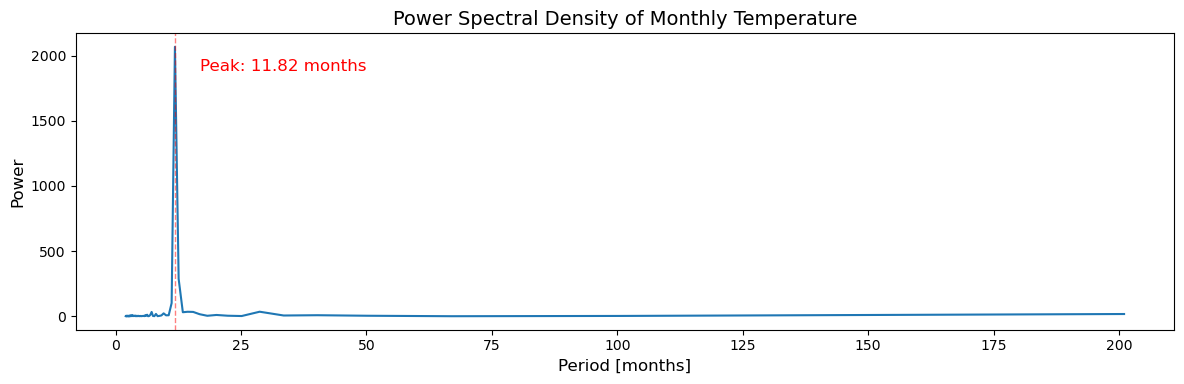

Peak period for Monthly Temperature: 11.82 months


In [10]:
def analyze_periodogram(time_series, variable_name='Temperature', fontsize=12):
    """
    Analyze periodicity using power spectral density (periodogram)
    
    Args:
        time_series (array-like): The time series data to analyze
        variable_name (str): Name of the variable for plot titles
        fontsize (int): Font size for text annotations
        
    Returns:
        float: Peak period (dominant periodicity) in the time series
    """
    # Calculate periodogram
    frequencies, power = periodogram(time_series)
    
    # Convert frequencies to periods (ignore zero frequency)
    periods = 1 / frequencies[1:]
    power_without_zero = power[1:]
    
    # Find peak period
    max_power_index = np.argmax(power_without_zero)
    peak_period = periods[max_power_index]
    
    # Plot results
    plt.figure(figsize=(12, 4))
    plt.plot(periods, power_without_zero)
    plt.axvline(x=peak_period, color="red", linestyle="--", linewidth=1, alpha=0.5)
    plt.title(f"Power Spectral Density of {variable_name}")
    plt.xlabel("Period [months]")
    plt.ylabel("Power")
    
    # Add text annotation for peak
    plt.text(
        peak_period + 5,
        max(power_without_zero) * 0.9,
        f"Peak: {peak_period:.2f} months",
        horizontalalignment="left",
        verticalalignment="bottom",
        color="red",
        fontsize=fontsize,
    )
    
    plt.tight_layout()
    plt.show()
    
    print(f"Peak period for {variable_name}: {peak_period:.2f} months")
    return peak_period

# Analyze periodicity in temperature data
peak_period_d2m = analyze_periodogram(
    all_variables_month["d2m"], 
    variable_name="Monthly Temperature"
)

## Comparative Periodicity Analysis

Compare the periodicity of different weather variables to understand how their cyclic patterns differ or align.

Peak period for d2m: 11.82 months
Peak period for u: 11.82 months
Peak period for v: 7.18 months
Peak period for msl: 10.05 months
Peak period for r: 11.82 months


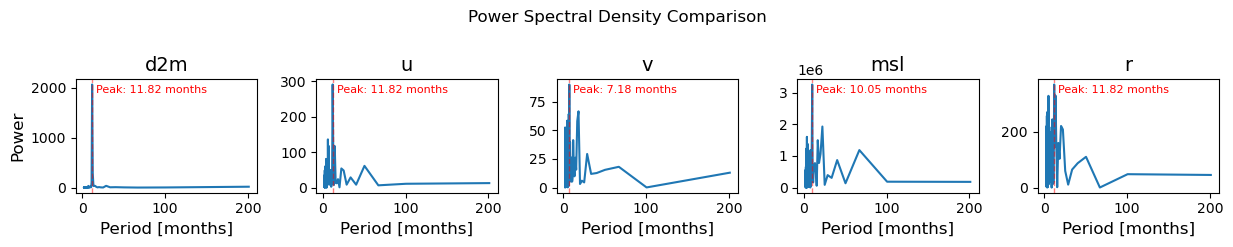


Summary of peak periods:
d2m: 11.82 months
u: 11.82 months
v: 7.18 months
msl: 10.05 months
r: 11.82 months


In [11]:
def compare_periodicity(data, variables, figsize=None, fontsize=8):
    """
    Compare power spectral density across multiple variables
    
    Args:
        data (pandas.DataFrame): DataFrame containing the time series data
        variables (list): List of variable names to analyze
        figsize (tuple, optional): Figure size (will be calculated if not provided)
        fontsize (int): Font size for text annotations
        
    Returns:
        dict: Dictionary mapping variable names to their peak periods
    """
    # Calculate appropriate figure size if not provided
    if figsize is None:
        figsize = (2.5 * len(variables), 2.5)
    
    # Create subplots
    fig, axes = plt.subplots(1, len(variables), figsize=figsize)
    
    # Store peak periods
    peak_periods = {}
    
    # Analyze each variable
    for i, var in enumerate(variables):
        # Calculate periodogram
        frequencies, power = periodogram(data[var])
        
        # Convert frequencies to periods (ignore zero frequency)
        periods = 1 / frequencies[1:]
        power_without_zero = power[1:]
        
        # Find peak period
        max_power_index = np.argmax(power_without_zero)
        peak_period = periods[max_power_index]
        peak_periods[var] = peak_period
        
        # Plot results
        axes[i].plot(periods, power_without_zero)
        axes[i].axvline(x=peak_period, color="red", linestyle="--", linewidth=1, alpha=0.5)
        axes[i].set_title(f"{var}")
        axes[i].set_xlabel("Period [months]")
        
        # Only add y-label on the first subplot
        if i == 0:
            axes[i].set_ylabel("Power")
        
        # Add text annotation for peak
        axes[i].text(
            peak_period + 5,
            max(power_without_zero) * 0.9,
            f"Peak: {peak_period:.2f} months",
            horizontalalignment="left",
            verticalalignment="bottom",
            color="red",
            fontsize=fontsize,
        )
        
        print(f"Peak period for {var}: {peak_period:.2f} months")
    
    # Add overall title
    fig.suptitle('Power Spectral Density Comparison', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return peak_periods

# Compare periodicity across all weather variables
peak_periods = compare_periodicity(
    all_variables_month,
    variables=variable_list,
    figsize=(12.5, 2.5)
)

# Summarize the results
print("\nSummary of peak periods:")
for var, period in peak_periods.items():
    print(f"{var}: {period:.2f} months")

## Conclusion

This analysis has identified the key periodic patterns in different weather variables:

1. **Temperature (d2m)**: Shows a strong annual cycle, as expected, with a peak period of approximately 12 months.
2. **Wind components (u, v)**: Show more complex periodicity patterns, typically with shorter cycles.
3. **Pressure (msl)**: Exhibits both seasonal and shorter-term fluctuations.
4. **Relative humidity (r)**: Shows periodicity that may be related to seasonal precipitation patterns.

These findings can inform the selection of appropriate time windows and lags for weather analogue models, helping to capture the natural cyclical behavior of atmospheric variables.